#**Big Data Management Exam 2020**
###Predicting successfull startups
Business Administration and Information Systems, Copenhagen Business School

###**Import of data and relevant libaries**

In [ ]:
from google.colab import drive, files
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,RepeatedStratifiedKFold,StratifiedKFold
from imblearn.over_sampling import SMOTE

drive.mount('/content/drive/')
%cd /content/drive/My Drive/CBS

startup_df = pd.read_csv("investments_VC.csv", delimiter=',', header = 0, encoding = "ISO-8859-1",skipinitialspace=True)
startup_df = startup_df.rename(columns={'market ': 'market', 'funding_total_usd ': 'funding_total_usd'})


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive/
/content/drive/My Drive/CBS


###**1.General overview**

In [ ]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4   market                45470 non-null  object 
 5   funding_total_usd     49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

In [ ]:
#Based on the .info() function, we can identify that some data variables need to be converted into a date type.
format_date = ('founded_at','first_funding_at','last_funding_at')
for i in format_date:
  startup_df[i] = pd.to_datetime(startup_df[i], format = '%Y-%m-%d', errors = 'coerce')

In [ ]:
startup_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   permalink             49438 non-null  object        
 1   name                  49437 non-null  object        
 2   homepage_url          45989 non-null  object        
 3   category_list         45477 non-null  object        
 4   market                45470 non-null  object        
 5   funding_total_usd     49438 non-null  object        
 6   status                48124 non-null  object        
 7   country_code          44165 non-null  object        
 8   state_code            30161 non-null  object        
 9   region                44165 non-null  object        
 10  city                  43322 non-null  object        
 11  funding_rounds        49438 non-null  float64       
 12  founded_at            38553 non-null  datetime64[ns]
 13  founded_month   

In [ ]:
startup_df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,2.074286e+06,6.088736e+05,4.434360e+05,3.845592e+04,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,3.167231e+07,2.678348e+07,3.428169e+07,3.864461e+06,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,3.500000e+09,4.700000e+09,5.800000e+09,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


###**2.Initial Data Preparation**
Preparing for exploration

In [ ]:
startup_df.head(1)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#To reduce the complexity, while processing the date variable fields, we convert the actual dates to 
#relative dates, describing the distance from founded to first and last funding and then drop the founded date.

startup_df['age_first_funding'] = (startup_df['first_funding_at']-startup_df['founded_at'])/pd.Timedelta(days=365)
startup_df['age_last_funding'] = (startup_df['last_funding_at']-startup_df['founded_at'])/pd.Timedelta(days=365)
startup_df['founded_month'] = pd.DatetimeIndex(startup_df['founded_at']).month
startup_df['founded_quarter'] = pd.DatetimeIndex(startup_df['founded_at']).quarter


In [ ]:
startup_df.isnull().sum()

permalink                4856
name                     4857
homepage_url             8305
category_list            8817
market                   8824
funding_total_usd        4856
status                   6170
country_code            10129
state_code              24133
region                  10129
city                    10972
funding_rounds           4856
founded_at              15741
founded_month           15741
founded_quarter         15741
founded_year            15812
first_funding_at         4866
last_funding_at          4862
seed                     4856
venture                  4856
equity_crowdfunding      4856
undisclosed              4856
convertible_note         4856
debt_financing           4856
angel                    4856
grant                    4856
private_equity           4856
post_ipo_equity          4856
post_ipo_debt            4856
secondary_market         4856
product_crowdfunding     4856
round_A                  4856
round_B                  4856
round_C   

In [ ]:
#As the dataset contains quite many null-values, we try to reduce the amount null-values by
#deleting the rows with a few central variables containing null
startup_df = startup_df.drop(startup_df[
                                        (
                                        (startup_df['status'].isna())|
                                        (startup_df['founded_month'].isna())|
                                        (startup_df['founded_year'].isna())|
                                        (startup_df['market'].isna())|
                                        (startup_df['country_code'].isna())|
                                        (startup_df['funding_total_usd'].isna())|
                                        (startup_df['age_first_funding'].isna())
                                        )
                                        ].index)
#With a general removal of all observations containing null-values, we have 28290 observations remaining
startup_df.shape

(33147, 41)

In [ ]:
#Based on the cleaning above, we would now like to see, 
#how many observations for each column that contains null-values.

startup_df.isnull().sum()

permalink                  0
name                       0
homepage_url            1621
category_list              0
market                     0
funding_total_usd          0
status                     0
country_code               0
state_code              9909
region                     0
city                     387
funding_rounds             0
founded_at                 0
founded_month              0
founded_quarter            0
founded_year               0
first_funding_at           0
last_funding_at            0
seed                       0
venture                    0
equity_crowdfunding        0
undisclosed                0
convertible_note           0
debt_financing             0
angel                      0
grant                      0
private_equity             0
post_ipo_equity            0
post_ipo_debt              0
secondary_market           0
product_crowdfunding       0
round_A                    0
round_B                    0
round_C                    0
round_D       

In [ ]:
#Excluding irrelevant variables, assumed cannot be used to predict the success of a start-up
#Funding_total_USD is excluded, as this is an aggregation of angel and seed

#We, however keep the name of the startup to correctly distinct between them the futher analysis
startup_df = startup_df.drop(
    [
     'permalink'
#     ,'name'
     ,'homepage_url'
     ,'state_code'
     ,'region'
     ,'city'
     ,'founded_at'
     ,'first_funding_at'
     ,'funding_total_usd'
     ,'last_funding_at'
     ,'category_list'
     ], axis = 1)

In [ ]:
#Further, we can check that we do not have any duplicates in our dataset
startup_df = startup_df.drop_duplicates()
startup_df.shape

(33147, 31)

In [ ]:
print('Before')
display(startup_df.groupby('status').agg({'country_code':'count'}).sort_values(by=['status'], ascending = False))
StatusDict = {"closed":0,"acquired":1}

startup_df = startup_df[(startup_df['status'] == 'acquired') | (startup_df['status'] == 'closed')]
startup_df["status_binary"] = startup_df["status"].map(StatusDict)
startup_df = startup_df.drop(['status'], axis = 1)
print('After')
display(startup_df.groupby('status_binary').agg({'country_code':'count'}).sort_values(by=['status_binary'], ascending = True))


Before


,country_code
status,
operating,28667
closed,1717
acquired,2763


After


,country_code
status_binary,
0,1717
1,2763


In [ ]:
#Hence, the format of funding_total_USD is distorted, we are aggregating a new attribute 

startup_df['total_investment'] = startup_df['seed'] + startup_df['venture'] +startup_df['equity_crowdfunding'] + startup_df['undisclosed'] + startup_df['convertible_note'] + startup_df['debt_financing'] + startup_df['angel'] + startup_df['grant'] + startup_df['private_equity'] + startup_df['post_ipo_equity'] + startup_df['post_ipo_debt'] + startup_df['secondary_market'] + startup_df['product_crowdfunding']

startup_df['total_investment'].describe()



count    4.480000e+03
mean     1.654188e+07
std      9.863946e+07
min      0.000000e+00
25%      3.000000e+05
50%      3.366250e+06
75%      1.440000e+07
max      5.700000e+09
Name: total_investment, dtype: float64

In [ ]:
max(startup_df['total_investment'])

5700000000.0

###**3. Data Preparation**
Preparing for modelling


In [ ]:
#Exporting data to .CSV in order to explore data in Tableau
#startup_df.to_csv(r'startup_df_v1.csv', index = False, sep=';',mode='w')
#files.download('startup_df_v1.csv')

In [ ]:
startup_df.shape

(4480, 32)

#### 3.1 Funding sum and rounds

In [ ]:
#Removing outliers via IQR: Interquartile range, also called midspread.

Q1 = startup_df['total_investment'].quantile(0.25)
Q3 = startup_df['total_investment'].quantile(0.75)
IQR = Q3 - Q1

fund_lower = (Q1 - 1.5 * IQR)
fund_upper = (Q3 + 1.5 * IQR)

startup_df = startup_df[
                        (startup_df['total_investment'] >= fund_lower ) 
                        & (startup_df['total_investment'] <= fund_upper)
                        ]

print('The following code remove all datapoints below: {} and above {}'.format(fund_lower, fund_upper))
print('This results in the following data model: {}'.format(startup_df.shape))

The following code remove all datapoints below: -20850000.0 and above 35550000.0
This results in the following data model: (4011, 32)


#### 3.2 Markets


In [ ]:
top20_markets = startup_df['market'].value_counts()[:20].keys().tolist()
startup_df['market'] = startup_df['market'].apply(lambda i: i if i in top20_markets else 'Other')

#### 3.3 Age when funded

In [ ]:
#It looks like, some startups have recived funding prior to the date of establishment.

#startup_df['age_first_funding'] = startup_df['age_first_funding'].clip(lower=0, upper=None)
#startup_df['age_last_funding'] = startup_df['age_last_funding'].clip(lower=0, upper=None)


startup_df.loc[startup_df['age_first_funding'] < 0, 'age_first_funding'] = 0
startup_df.loc[startup_df['age_last_funding'] < 0, 'age_first_funding'] = 0

#### 3.4 Age when founded


In [ ]:
#The majority of the startups are located after 1994
#To further reduce the amount of outliers, we are excluding all startups before 1995.

startup_df = startup_df[(startup_df['founded_year'] >= 1995.0 )]

#### 3.5 Geographical data

In [ ]:
startup_df = startup_df.drop(
    [
     'country_code'
     ,'name'
     ], axis = 1)

#### 3.6 Correlation matrix


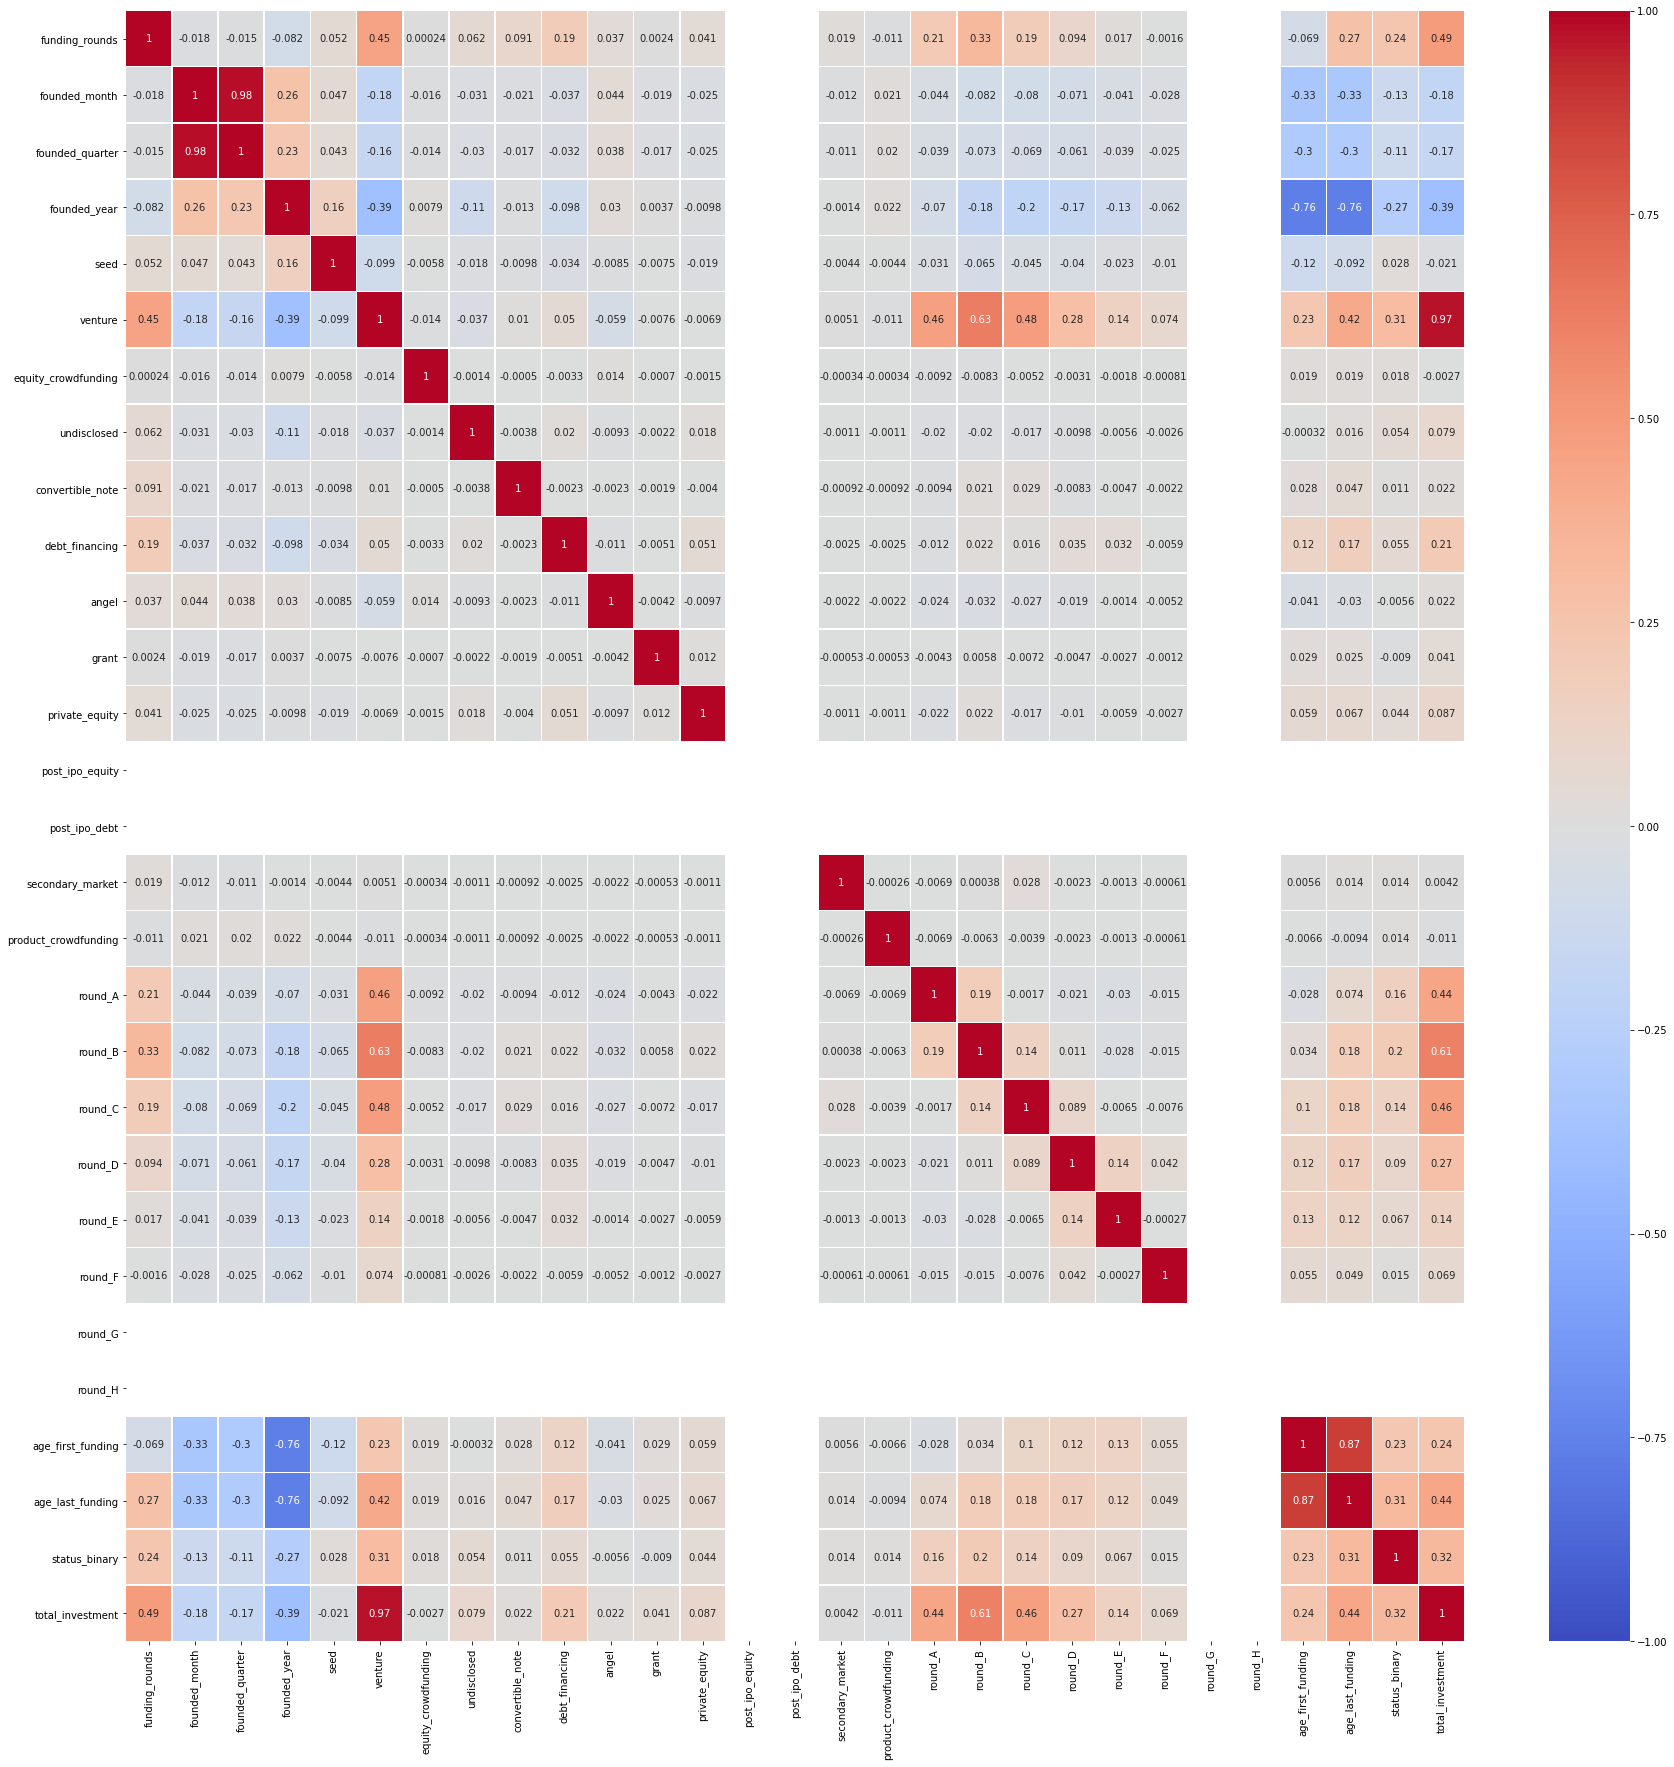

In [ ]:
plt.figure(figsize=(30,30))
startup_heat = startup_df.corr()

startup_heat= sns.heatmap(startup_heat, annot=True,linewidth = 0.5, cmap='coolwarm', vmin=-1, vmax=1)

bottom, top = startup_heat.get_ylim()
startup_heat.set_ylim(bottom, top)

plt.show()

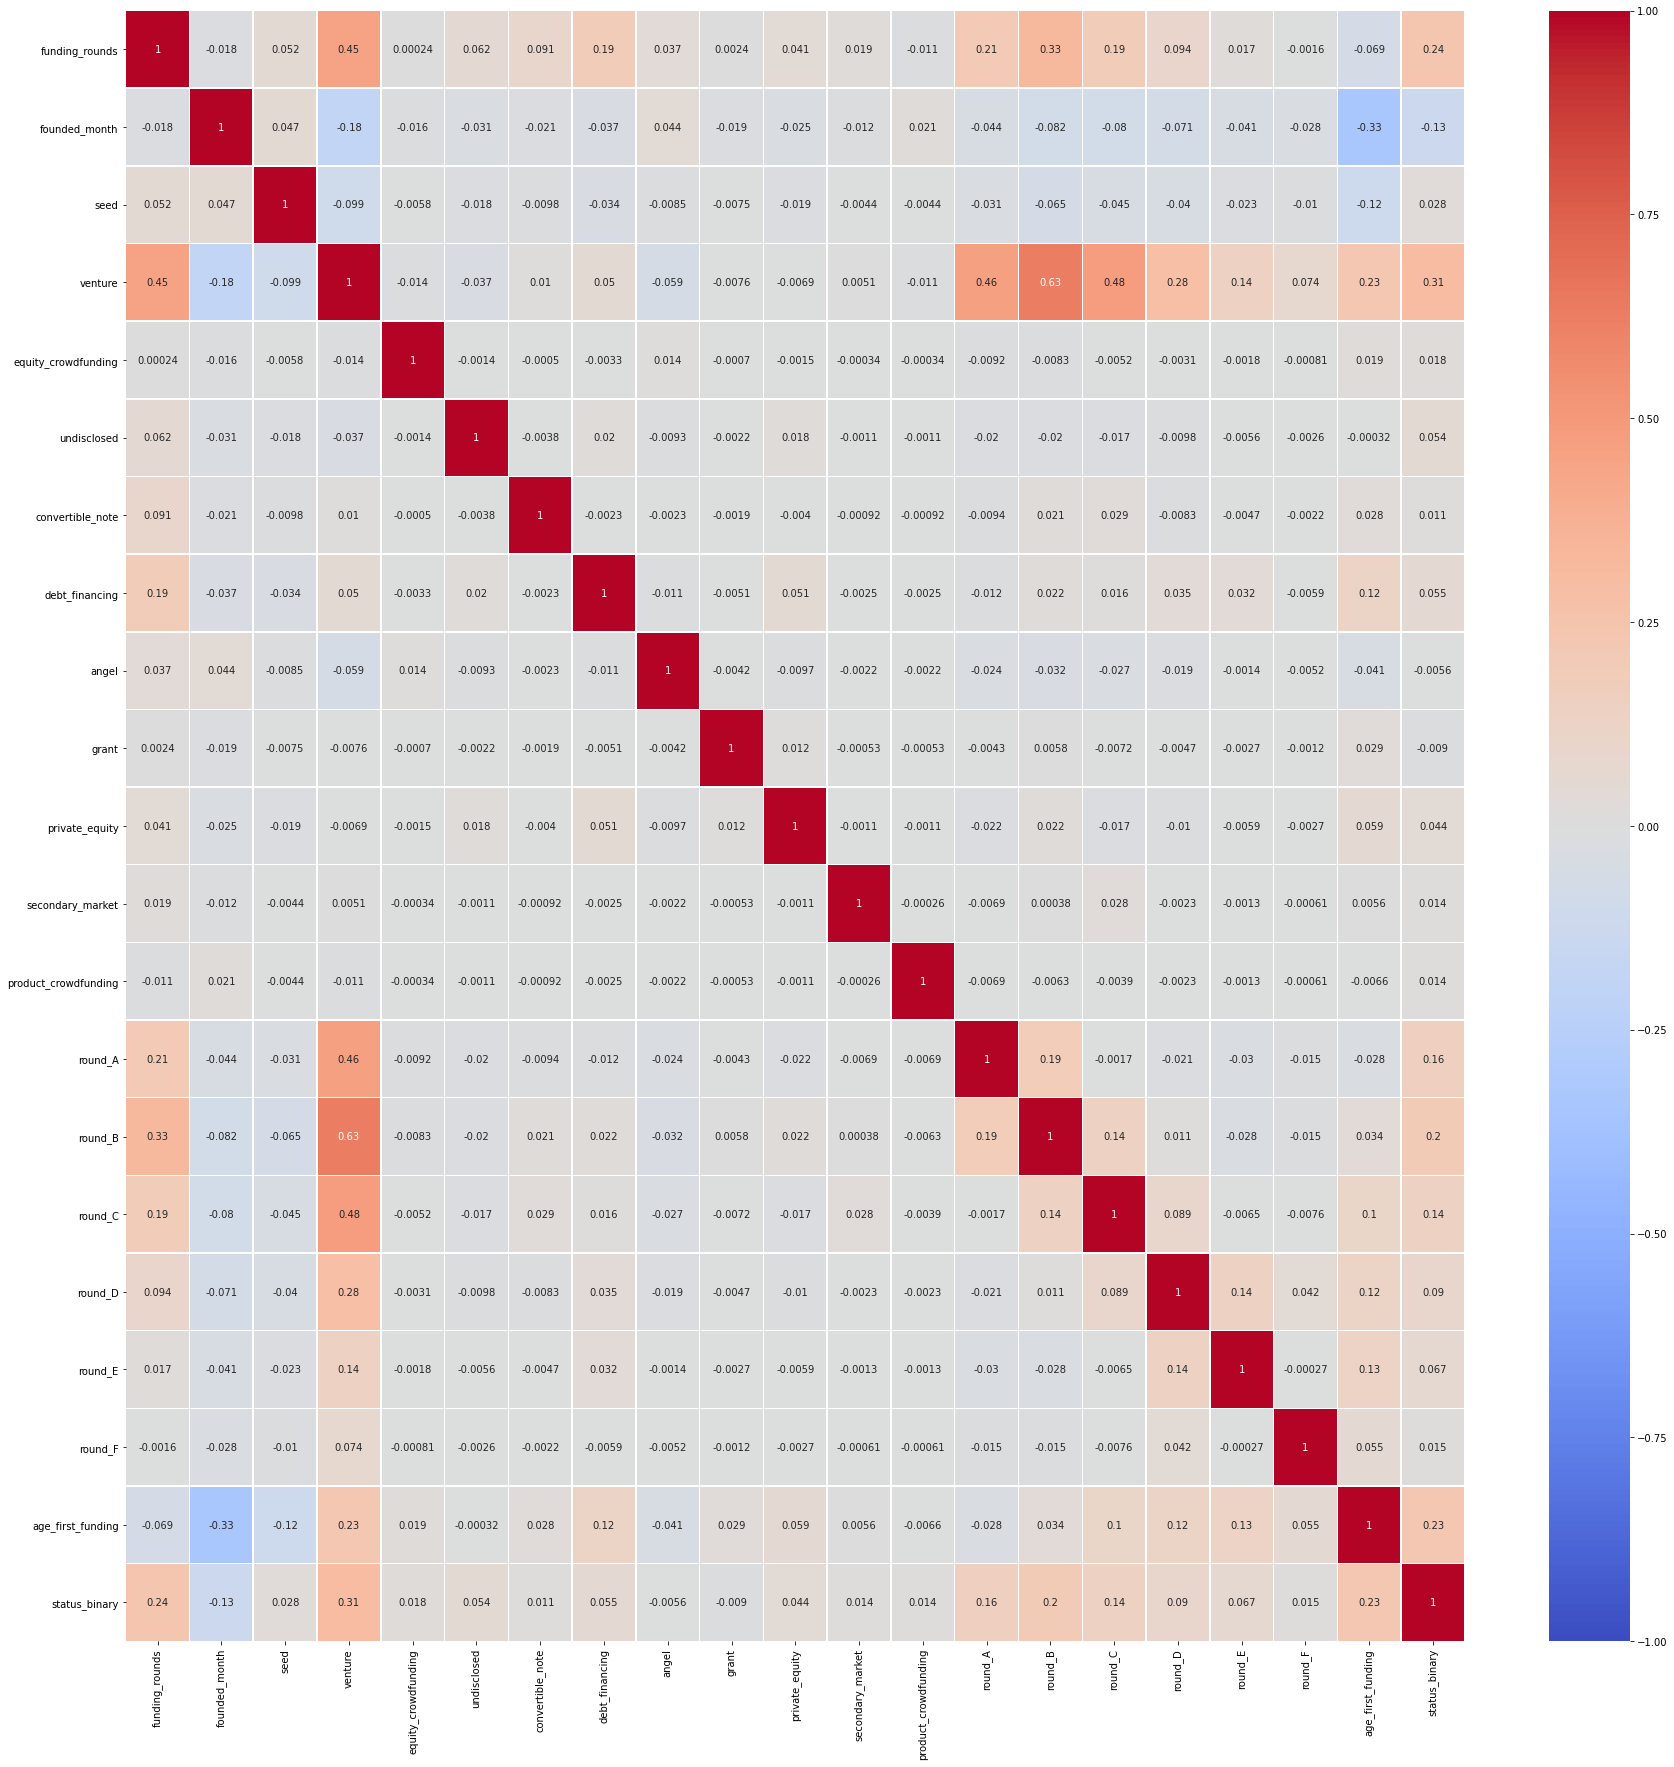

In [ ]:
#Hence, the correlation of a few different attributes are blank
#we are further excluding these from the model
startup_df = startup_df.drop(
    [
     'post_ipo_equity'
     ,'post_ipo_debt'
     ,'round_G'
     ,'round_H'
     ,'founded_year'
     ,'founded_quarter'
     ,'total_investment'
     ,'age_last_funding'
     ], axis = 1)

plt.figure(figsize=(30,30))
startup_heat = startup_df.corr()

startup_heat= sns.heatmap(startup_heat, annot=True,linewidth = 0.5, cmap='coolwarm', vmin=-1, vmax=1)

bottom, top = startup_heat.get_ylim()
startup_heat.set_ylim(bottom, top)

plt.show()

#### 3.7 Exporting data to Tableau



In [ ]:
#Exporting data to .CSV in order to explore data in Tableau
#startup_df.to_csv(r'startup_df_v2.csv', index = False, sep=';',mode='w')
#files.download('startup_df_v2.csv')

###**4. Data Modelling and Tuning**
Predicting successful start-ups


In [ ]:
#The initial process of the modelling phase is to create dummy variables
#and seperating the dataset into X and y

modelling_df = startup_df
X = pd.get_dummies(modelling_df.drop(['status_binary'],axis = 1))
y = modelling_df['status_binary']

In [ ]:
#Before modelling our data, we are creating a new dataframe, to reduce the complexity
#Further, we are the data into train and test identify potential overfitting patterns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 10)

#### 4.1 Random Forrest Classification




In [ ]:
#Testing the impact of increasing desicion trees used to predict y.
n = 10
while n <= 200:
  model = RandomForestClassifier(n_estimators=n)
  model.fit(X_train, y_train)
  print('{} - train score: {:.3f} | test score: {:.3f}'.format(n,model.score(X_train,y_train),model.score(X_test,y_test)))
  n = n+10

10 - train score: 0.970 | test score: 0.681
20 - train score: 0.986 | test score: 0.697
30 - train score: 0.990 | test score: 0.711
40 - train score: 0.991 | test score: 0.701
50 - train score: 0.992 | test score: 0.711
60 - train score: 0.991 | test score: 0.708
70 - train score: 0.992 | test score: 0.709
80 - train score: 0.992 | test score: 0.710
90 - train score: 0.992 | test score: 0.708
100 - train score: 0.992 | test score: 0.715
110 - train score: 0.992 | test score: 0.712
120 - train score: 0.992 | test score: 0.709
130 - train score: 0.992 | test score: 0.715
140 - train score: 0.992 | test score: 0.709
150 - train score: 0.992 | test score: 0.705
160 - train score: 0.992 | test score: 0.713
170 - train score: 0.992 | test score: 0.714
180 - train score: 0.992 | test score: 0.707
190 - train score: 0.992 | test score: 0.717
200 - train score: 0.992 | test score: 0.715


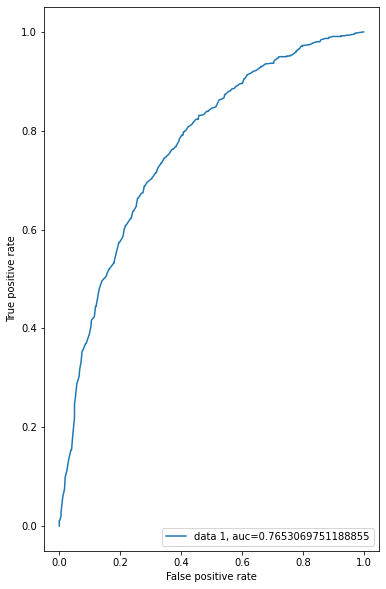

In [ ]:
model = RandomForestClassifier(n_estimators=110) 
model.fit(X_train, y_train)

#ROC CURVE - Plotting the true positives against the false positives and an AUC score
y_pred_proba = model.predict_proba(X_test) [:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

##### 4.2.1 Model tuning

In [ ]:
#To get an overview of the feature importance we can utilize from the
#The feature_importances_ function was not used, because of bias when dealing with a high cardinality (according to the SKlearn documentation)
result = permutation_importance(model, X_train, y_train, n_repeats=10,random_state=0)
fimp = pd.Series(result.importances_mean,index=X_train.columns.values).sort_values(ascending=False)
fimp

age_first_funding              0.154898
venture                        0.152710
funding_rounds                 0.122675
founded_month                  0.082546
seed                           0.068076
market_Other                   0.053357
round_A                        0.039433
round_B                        0.028294
angel                          0.017802
market_Software                0.015017
market_Curated Web             0.013078
debt_financing                 0.009000
round_C                        0.007608
market_Enterprise Software     0.007509
market_Social Media            0.007360
market_Biotechnology           0.006315
market_Advertising             0.006315
market_Mobile                  0.005221
market_Games                   0.004674
market_E-Commerce              0.004326
market_Semiconductors          0.003431
round_D                        0.003033
market_Security                0.002089
market_Clean Technology        0.001989
market_Hardware + Software     0.001939


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


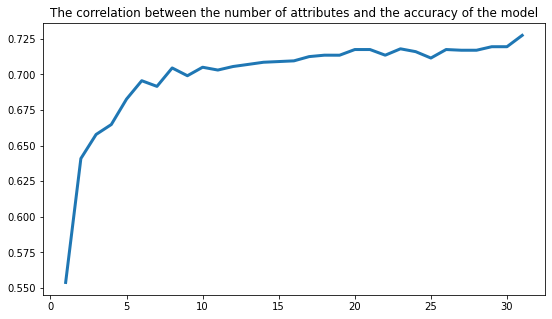

In [ ]:
#Based on the model accuracy from above, we can try to tune the performance by
#evaluating the accuracy by random selecting a number of decriptive attributes
#Further, we evaluate the model by the isolated attribute importance and then dropping insignificant attributes.

rfecv = RFECV(estimator=model, step=1,cv=StratifiedKFold(10),scoring='accuracy')
rfecv.fit(X_train,y_train)

plt.figure(figsize=(9,5))
plt.plot(range(1, len(rfecv.grid_scores_)+1),rfecv.grid_scores_,linewidth=3)
plt.title('The correlation between the number of attributes and the accuracy of the model')
plt.show()



In [ ]:
X_train.columns[np.where(rfecv.support_ == False)[0]]

Index(['equity_crowdfunding', 'secondary_market', 'product_crowdfunding',
       'round_F'],
      dtype='object')

In [ ]:
#Based on the plot above, we are dropping all columns not categorized as supportive to our model
X.drop(X_train.columns[np.where(rfecv.support_ == False)[0]],axis=1, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
result = permutation_importance(model, X_train, y_train, n_repeats=10,random_state=0)
fimp = pd.Series(result.importances_mean,index=X_train.columns.values).sort_values(ascending=False)
fimp

age_first_funding              0.229402
venture                        0.171665
seed                           0.091099
founded_month                  0.081619
round_A                        0.062269
funding_rounds                 0.059286
round_B                        0.041022
angel                          0.032121
debt_financing                 0.025063
market_Other                   0.019715
round_C                        0.016615
market_Software                0.014275
market_Curated Web             0.012551
market_Mobile                  0.010418
market_Games                   0.009984
market_Biotechnology           0.009630
market_Social Media            0.009520
market_Enterprise Software     0.008538
market_Advertising             0.008322
market_E-Commerce              0.007370
market_Hardware + Software     0.006803
round_D                        0.006509
undisclosed                    0.006173
market_Clean Technology        0.006055
market_Finance                 0.006001


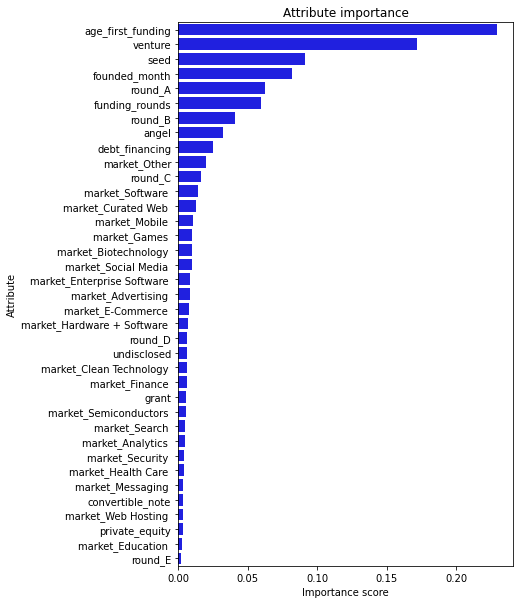

In [ ]:
#Plotting feature importance
sns.barplot(x=fimp, y=fimp.index, color='b')
plt.rcParams['figure.figsize'] = 6,10
plt.xlabel('Importance score')
plt.ylabel('Attribute')
plt.title('Attribute importance')

plt.show()

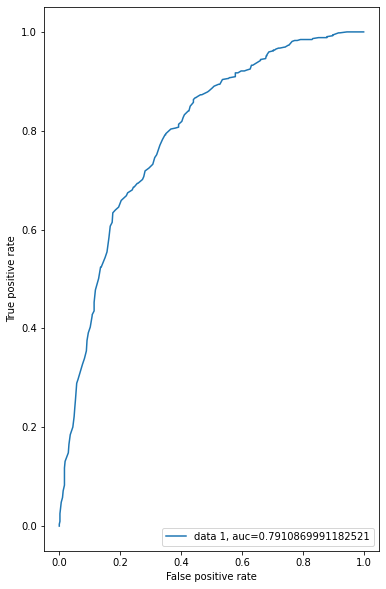

In [ ]:
#Plotting another ROC curve to benchmark the initial model against the tuned version.
y_pred_proba = model.predict_proba(X_test) [:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
#Further, we create a new model, embedded with a cross-validation to evaluate the performance of the model across 10 folds repeating 5 times
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cross_val, n_jobs=-1, error_score='raise')
# report performance
print('Average score of 5 run with a stratified 10 Kfold is {:.3f} with a standard deviation of: {:.3f}'.format(np.mean(scores)*100, np.std(scores)))

Average score of 5 run with a stratified 10 Kfold is 70.097 with a standard deviation of: 0.024


#### 4.2 Logistic regression




In [ ]:
#To evaluate the true performance of a logistic regression, we are once again including all attributes
X = pd.get_dummies(modelling_df.drop(['status_binary'],axis = 1))
y = modelling_df['status_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

The training model accuracy: 0.6042
The test model accuracy: 0.5887


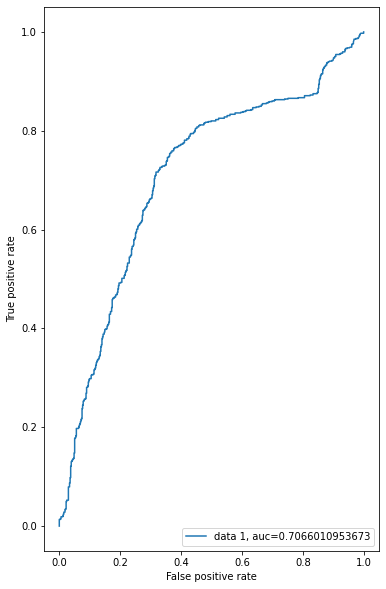

In [ ]:
#ROC CURVE - Plotting the true positives against the false positives
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

##### 4.1.1 Model tuning

In [ ]:
#Trying to balance the classes in order to achieve a better result
logreg = LogisticRegression(max_iter=10000,class_weight='balanced')
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

The training model accuracy: 0.6809
The test model accuracy: 0.6607


In [ ]:
#Fitting the model with both a balanced and the liblinear as the solver
#**Liblinear is described in docu as a solid choice for small datasets**
logreg = LogisticRegression(penalty='l1', solver='liblinear',class_weight='balanced', max_iter=10000)
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

The training model accuracy: 0.701
The test model accuracy: 0.6615


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
#Fitting the model with both a balanced and 
#from sklearn.metrics import mean_squared_error
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)
logreg.fit(X_train,y_train)

print('The training model accuracy: {:.4}'.format(logreg.score(X_train,y_train)))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)))

#print('Mean square error: {:.4}'.format(mean_squared_error(y_test, y_train)))
#print('Root mean square error: {:.4}'.format(mean_squared_error(y_test, y_train)))

The training model accuracy: 0.7272
The test model accuracy: 0.6982


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


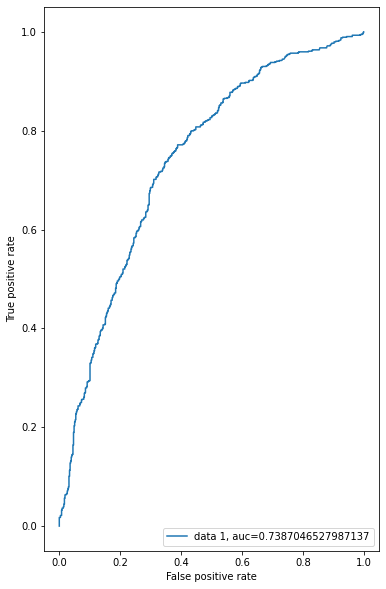

In [ ]:
#ROC CURVE - Plotting the true positives against the false positives
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

In [ ]:
#******************************NOTE*****************************

#**********Cannot get this GridSearch function to work**********

#To optimize the logistic regression model, we can make use of hyperparamter tuning
#which uses the gridSearch cross-validation function to go through different parameters
#in order to find the parameters, that can provide the best possible outcome (accuracy)

#First, we define a parameter grid, which can be describe as the parameters to choose from
param_list = [
              {'penalty' :['l1','l2','elasticnet','none']
               ,'solver' : ['lbfgs','newton-cg','liblinear','sag','saga']
               ,'max_iter' : [500,1000,4000,8000]
               }
]

#from sklearn.model_selection import GridSearchCV
#cvf = GridSearchCV(logreg, param_grid = param_list, cv = 3, verbose=True, n_jobs=1)
#optimal_cvf = cvf.fit(X,y)

#******************************NOTE*****************************


###**5. Data Evaluation**
Predicting successful start-ups


In [ ]:
modelling_df.groupby('status_binary').agg({'status_binary':'count'})

,status_binary
status_binary,
0,1619
1,2255


*Hence our dataset is inbalanced, we can apply SMOTE to balance the difference between successfull and non-successfull startups. SMOTE is using knearestneighbor, to create new rows by not copying but rather simulating existing rows.*


*We can the try to apply SMOTE to the training data and they carry out the two ML models from the previous chapter once again.*

*However, it is important, that we only do a SMOTE on the training data, because information from the target variable then is restricted to only training and the real performance of the test is then isolated.*

In [ ]:
modelling_df = startup_df
X = pd.get_dummies(modelling_df.drop(['status_binary'],axis = 1))
y = modelling_df['status_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)



In [ ]:
os = SMOTE(random_state=11)
col = X_train.columns

os_X,os_y=os.fit_resample(X_train, y_train)
os_X = pd.DataFrame(data= os_X,columns = col )
os_y = pd.DataFrame(data= os_y,columns = ['y'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Then we can evaluate the SMOTE function, to understand how we have extended our data

print("length of undersampled data is ",len(os_X))
print("Number of closed startups in undersampled data",len(os_y[os_y['y']==0]))
print("Number of succesfull startups",len(os_y[os_y['y']==1]))
print("Proportion of closed startups in undersampled data is {}%".format(len(os_y[os_y['y']==0])/len(os_X)*100))
print("Proportion of succesfull startups in undersampled data is {}%".format(len(os_y[os_y['y']==1])/len(os_X)*100))

length of oversampled data is  3002
Number of closed startups in oversampled data 1501
Number of succesfull startups 1501
Proportion of closed startups in oversampled data is 50.0%
Proportion of succesfull startups in oversampled data is 50.0%


##### 5.3 Random forrest w. balanced data

In [ ]:
X = os_X
y = os_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


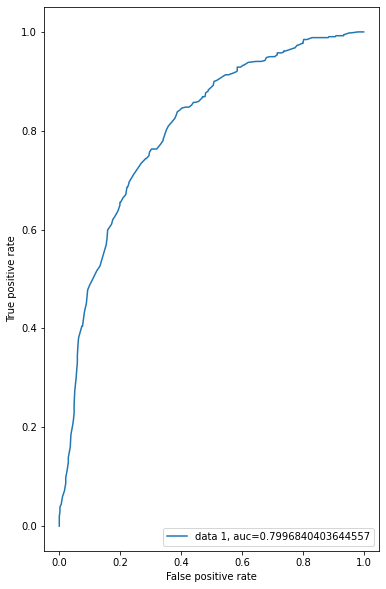

In [ ]:
model = RandomForestClassifier(n_estimators=110) 
model.fit(X_train, y_train)

#ROC CURVE - Plotting the true positives against the false positives and an AUC score
y_pred_proba = model.predict_proba(X_test) [:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()


> Hence, we did not recived great success while tuning the random forrest model from chapter 3, we leave the model and by it's original state and do not exclude attributes by performing a RFECV (Recursive Feature Elimination.Cross-alidation)




##### 5.2 Logistic regression w. balanced data

In [ ]:
X = os_X
y = os_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

In [ ]:
logreg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)
logreg.fit(os_X,os_y)

print('The training model accuracy (balanced): {:.4} %'.format(logreg.score(os_X,os_y)*100))
print('The test model accuracy: {:.4}'.format(logreg.score(X_test,y_test)*100))

The training model accuracy (balanced): 70.65 %
The test model accuracy: 70.53


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


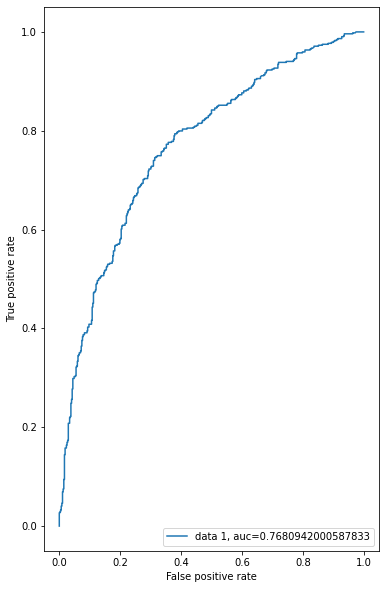

In [ ]:
#ROC CURVE - Plotting the true positives against the false positives
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc=4)
plt.show()

###**5. Deployment**
The deployment of a random forrest model to classify successfull startups.


In [ ]:
#Finally, we can try to use our model to predict a the future state of a startup in isolation
#To do this, we can make use of to predict function, but first we need to create a new dataframe with our target

#Training the model once again with the balanced data from SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

model.fit(X_train, y_train)
pred = X_test.sample(n=1)
outcome = model.predict(pred)

y_pred_proba = model.predict_proba(X_test) [:,1]
auc = metrics.roc_auc_score(y_test, y_pred_proba)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
  display(pred)
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
  display(pred)

#To use this in a real life setting, one could benefit from this by replacing 'pred' with another user based dataframe
#containing a startup with that has the potential of being a successfull startup and hereby also needed to be investigated
#This is shown below

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Predicted Class: 1
This startup is predicted to be successful by 79.1%


,funding_rounds,founded_month,seed,venture,debt_financing,angel,grant,round_A,round_B,round_C,round_D,age_first_funding,market_Advertising,market_Analytics,market_Biotechnology,market_Clean Technology,market_Curated Web,market_E-Commerce,market_Enterprise Software,market_Finance,market_Games,market_Hardware + Software,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
148,7.0,6.0,0.0,21700000.0,0.0,3200000.0,0.0,6200000.0,0.0,0.0,0.0,0.923288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train.head(1)

,funding_rounds,founded_month,seed,venture,debt_financing,angel,grant,round_A,round_B,round_C,round_D,age_first_funding,market_Advertising,market_Analytics,market_Biotechnology,market_Clean Technology,market_Curated Web,market_E-Commerce,market_Enterprise Software,market_Finance,market_Games,market_Hardware + Software,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
1826,1.0,1.0,0.0,4880000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.413699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
prod_dict = {'funding_rounds':              [1.0]
            ,'founded_month':               [9.0]
            ,'seed':                        [50000.0]
            ,'venture':                     [0.0]
            ,'debt_financing':              [0.0]
            ,'angel':                       [0.0]
            ,'grant':                       [3000.0]
            ,'round_A':                     [3000.0]
            ,'round_B':                     [50000.0]
            ,'round_C':                     [0.0]
            ,'round_D':                     [0.0]
            ,'age_first_funding':           [2.655]
            ,'market_Advertising':          [0.0]
            ,'market_Analytics ':           [0.0]
            ,'market_Biotechnology ':       [0.0]
            ,'market_Clean Technology ':    [0.0]
            ,'market_Curated Web ':         [0.0]
            ,'market_E-Commerce ':          [0.0]
            ,'market_Enterprise Software ': [1.0]
            ,'market_Finance ':             [0.0]
            ,'market_Games ':               [0.0]
            ,'market_Hardware + Software ': [0.0]
            ,'market_Messaging ':           [0.0]
            ,'market_Mobile ':              [0.0]
            ,'market_Other':                [0.0]
            ,'market_Search ':              [0.0]
            ,'market_Security':             [0.0]
            ,'market_Semiconductors ':      [0.0]
            ,'market_Social Media ':        [0.0]
            ,'market_Software ':            [0.0]
            ,'market_Web Hosting ':         [0.0]
            }
prod_pred = pd.DataFrame(data=prod_dict)
outcome = model.predict(prod_pred)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
display(prod_pred)

Predicted Class: 1
This startup is predicted to be successful by 79.1%


,funding_rounds,founded_month,seed,venture,debt_financing,angel,grant,round_A,round_B,round_C,round_D,age_first_funding,market_Advertising,market_Analytics,market_Biotechnology,market_Clean Technology,market_Curated Web,market_E-Commerce,market_Enterprise Software,market_Finance,market_Games,market_Hardware + Software,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
0,1.0,9.0,50000.0,0.0,0.0,0.0,3000.0,3000.0,50000.0,0.0,0.0,2.655,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tableau Software was recently acquired by Salesforce. However, they are categorized as a operational company in our dataset. To test the performance of our model, we can try see how the model perform on Tableau:

In [ ]:
prod_dict = {'funding_rounds':              [2.0]
            ,'founded_month':               [1.0]
            ,'seed':                        [0.0]
            ,'venture':                     [15000000.0]
            ,'debt_financing':              [0.0]
            ,'angel':                       [0.0]
            ,'grant':                       [3000.0]
            ,'round_A':                     [5000000.0]
            ,'round_B':                     [10000000.0]
            ,'round_C':                     [0.0]
            ,'round_D':                     [0.0]
            ,'age_first_funding':           [1.0]
            ,'market_Advertising':          [0.0]
            ,'market_Analytics ':           [0.0]
            ,'market_Biotechnology ':       [0.0]
            ,'market_Clean Technology ':    [0.0]
            ,'market_Curated Web ':         [0.0]
            ,'market_E-Commerce ':          [0.0]
            ,'market_Enterprise Software ': [0.0]
            ,'market_Finance ':             [0.0]
            ,'market_Games ':               [0.0]
            ,'market_Hardware + Software ': [0.0]
            ,'market_Messaging ':           [0.0]
            ,'market_Mobile ':              [0.0]
            ,'market_Other':                [0.0]
            ,'market_Search ':              [0.0]
            ,'market_Security':             [0.0]
            ,'market_Semiconductors ':      [0.0]
            ,'market_Social Media ':        [0.0]
            ,'market_Software ':            [1.0]
            ,'market_Web Hosting ':         [0.0]
            }
prod_pred = pd.DataFrame(data=prod_dict)
outcome = model.predict(prod_pred)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
display(prod_pred)

Predicted Class: 1
This startup is predicted to be successful by 79.1%


,funding_rounds,founded_month,seed,venture,debt_financing,angel,grant,round_A,round_B,round_C,round_D,age_first_funding,market_Advertising,market_Analytics,market_Biotechnology,market_Clean Technology,market_Curated Web,market_E-Commerce,market_Enterprise Software,market_Finance,market_Games,market_Hardware + Software,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
0,2.0,1.0,0.0,15000000.0,0.0,0.0,3000.0,5000000.0,10000000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Slack software

In [ ]:
prod_dict = {'funding_rounds':              [6.0]
            ,'founded_month':               [1.0]
            ,'seed':                        [1500000.0]
            ,'venture':                     [178450000.0]
            ,'debt_financing':              [0.0]
            ,'angel':                       [0.0]
            ,'grant':                       [0.0]
            ,'round_A':                     [5000000.0]
            ,'round_B':                     [10700000.0]
            ,'round_C':                     [42750000.0]
            ,'round_D':                     [120000000.0]
            ,'age_first_funding':           [0.0]
            ,'market_Advertising':          [0.0]
            ,'market_Analytics ':           [0.0]
            ,'market_Biotechnology ':       [0.0]
            ,'market_Clean Technology ':    [0.0]
            ,'market_Curated Web ':         [0.0]
            ,'market_E-Commerce ':          [0.0]
            ,'market_Enterprise Software ': [1.0]
            ,'market_Finance ':             [0.0]
            ,'market_Games ':               [0.0]
            ,'market_Hardware + Software ': [0.0]
            ,'market_Messaging ':           [0.0]
            ,'market_Mobile ':              [0.0]
            ,'market_Other':                [0.0]
            ,'market_Search ':              [0.0]
            ,'market_Security':             [0.0]
            ,'market_Semiconductors ':      [0.0]
            ,'market_Social Media ':        [0.0]
            ,'market_Software ':            [0.0]
            ,'market_Web Hosting ':         [0.0]
            }
prod_pred = pd.DataFrame(data=prod_dict)
outcome = model.predict(prod_pred)

print('Predicted Class: {}'.format(outcome[0]))

if outcome == 1:
  print('This startup is predicted to be successful by {:.1f}%'.format(auc*100)) 
elif outcome == 0:
  print('This startup is predicted NOT to be successful by {:.1f}%'.format(auc*100)) 
display(prod_pred)

Predicted Class: 1
This startup is predicted to be successful by 79.1%


,funding_rounds,founded_month,seed,venture,debt_financing,angel,grant,round_A,round_B,round_C,round_D,age_first_funding,market_Advertising,market_Analytics,market_Biotechnology,market_Clean Technology,market_Curated Web,market_E-Commerce,market_Enterprise Software,market_Finance,market_Games,market_Hardware + Software,market_Messaging,market_Mobile,market_Other,market_Search,market_Security,market_Semiconductors,market_Social Media,market_Software,market_Web Hosting
0,6.0,1.0,1500000.0,178450000.0,0.0,0.0,0.0,5000000.0,10700000.0,42750000.0,120000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
